<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [Phase-folded time-series variability plots](04.01-Lightcurve-postage_stamps_by_object.ipynb) | [Contents](Index.ipynb) | [Boutique photometry collection for V819 Tau](04.03-Boutique-photometry-analysis-V819Tau.ipynb) >

# Periodogram analysis demo of HD 283572

In this notebook we analyze ASASSN data.

|Source| Period found?| Amplitude found?|
|--|--|--|
|Anon 1|  |  |
|HD 283572|  |  |
|Hubble 4|  |  |
|LkCa 1|  |  |
|LkCa 4|  |  |
|LkCa 7|  |  |
|LkCa 14|  |  |
|LkCa 16|  |  |
|LkCa 19|  |  |
|TAP 35|  |  |
|TAP 41|  |  |
|TAP 45|  |  |
|V819 Tau|  |  |
|V826 Tau|  |  |
|V827 Tau|  |  |
|V836 Tau|  |  |

In [1]:
#import warnings
#warnings.filterwarnings("ignore")
#from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astroML.time_series
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle
from scipy.signal import argrelmax

Plot settings

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook', font_scale=1.0)
sns.set_style('ticks')

## Convenience functions for periodogram analysis
These were previously defined in [a notebook from the welter repository](https://github.com/BrownDwarf/welter/blob/master/notebooks/welter_issue018-05_fit_ASASSN_amplitudes_ESPaDoNs.ipynb).

In [3]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x = light_curve.time.values
    y = light_curve.flux.values
    yerr = light_curve.err.values
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [4]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [5]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.plot(lc.time, lc.flux, '.')
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

## HD 283572

In [6]:
HD283572_raw = pd.read_csv('../data/ASASSN/HD_283572_ASASSN_20170803.csv')

In [7]:
HD283572_raw.tail(2)

,HJD,UT Date,Camera,FWHM,Limit,mag,mag_err,flux(mJy),flux_err
620,2.457965e+06,2017-07-30.6048,bc,1.49,14.022,8.983,0.004,978.716,4.064
621,2.457965e+06,2017-07-30.6060677,bc,1.42,14.039,9.005,0.005,959.554,4.102


Mask outliers

In [8]:
inds = (HD283572_raw.mag < 20.0) & (HD283572_raw.mag == HD283572_raw.mag)

In [9]:
HD283572_raw = HD283572_raw[inds].reset_index()

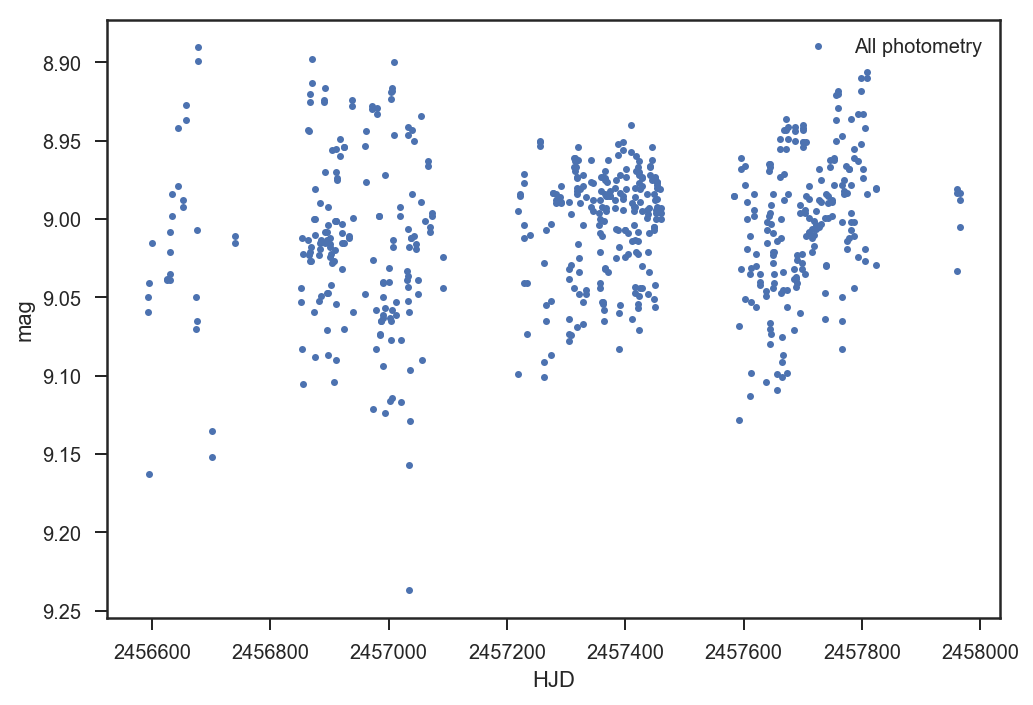

In [10]:
plt.plot(HD283572_raw.HJD, HD283572_raw.mag, '.', label='All photometry')
    
plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.xlabel('HJD')
plt.ylabel('mag');

In [11]:
x = HD283572_raw.HJD.values
y = HD283572_raw.mag.values
yerr = HD283572_raw.mag_err.values

In [12]:
light_curve = pd.DataFrame({"time":x, "flux":y, "err":yerr})

In [13]:
periods, P_M, P_LS = run_periodograms(light_curve)

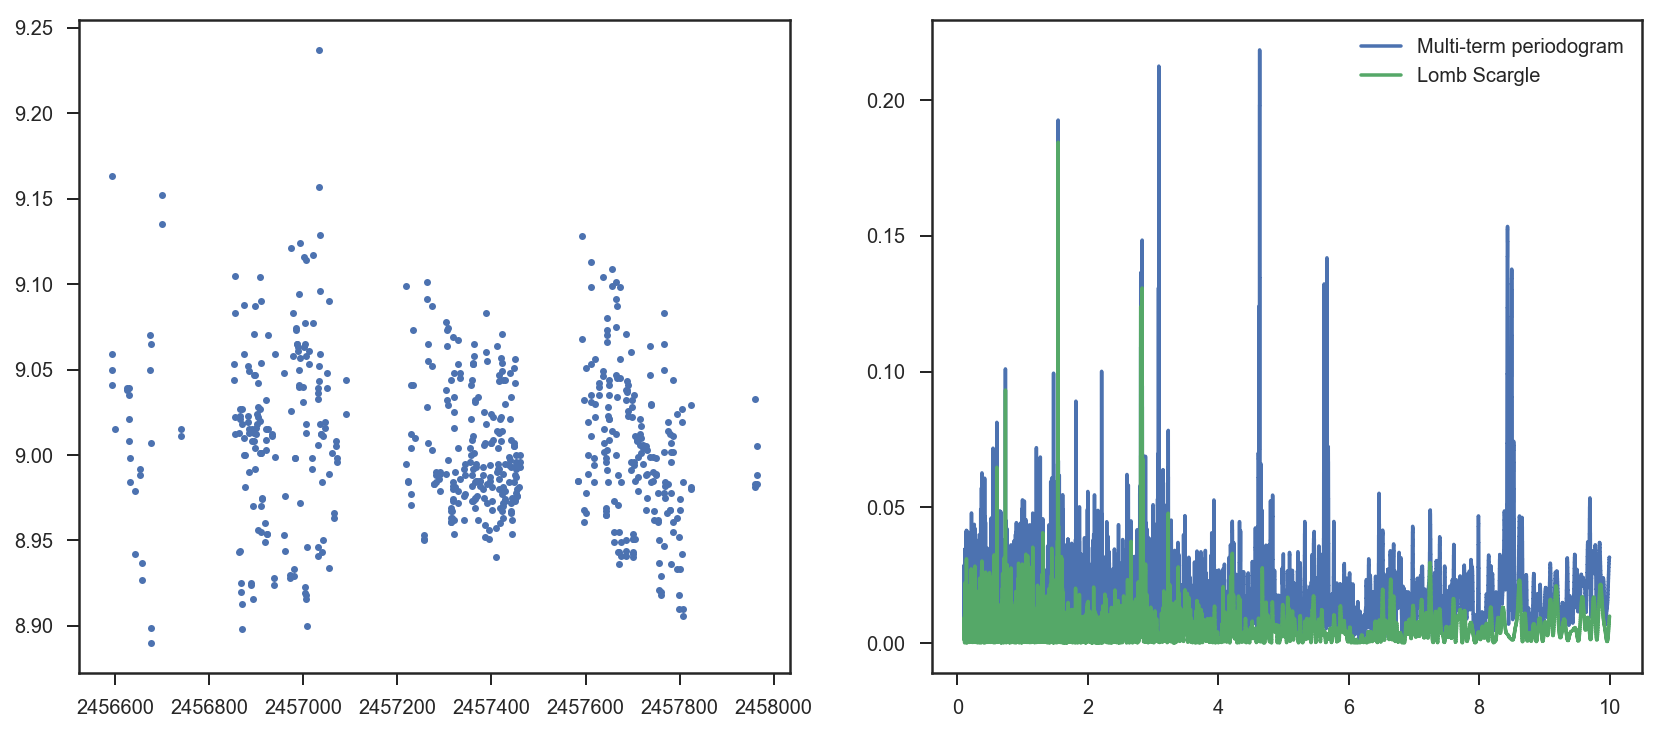

In [14]:
plot_LC_and_periodograms(light_curve, periods, P_M, P_LS)
plt.savefig('../results/periodgram_orig.pdf')

In [15]:
p_days_LS, X_sq_M = top_N_periods(periods, P_LS)
p_days_LS

array([ 1.54554455,  2.83366337,  2.81188119,  1.54257426,  0.73762376])

In [16]:
p_days_M, X_sq_LS = top_N_periods(periods, P_M)
p_days_M

array([ 4.63564356,  3.09009901,  1.54554455,  8.43663366,  2.83366337])

It looks like P~1.5455 days is the period

In [17]:
periods_fine, P_M_fine, P_LS_fine = run_periodograms(light_curve, P_range=[1.5, 1.6])

In [18]:
p_days_M, X_sq_LS = top_N_periods(periods_fine, P_M_fine, n=1)
P_fit = p_days_M[0]

In [19]:
print('The period is {:.4f} days'.format(P_fit))

The period is 1.5452 days


In [20]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.vander(x, 3)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x.min(), x.max(), 0.01)

A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                    np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                    np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

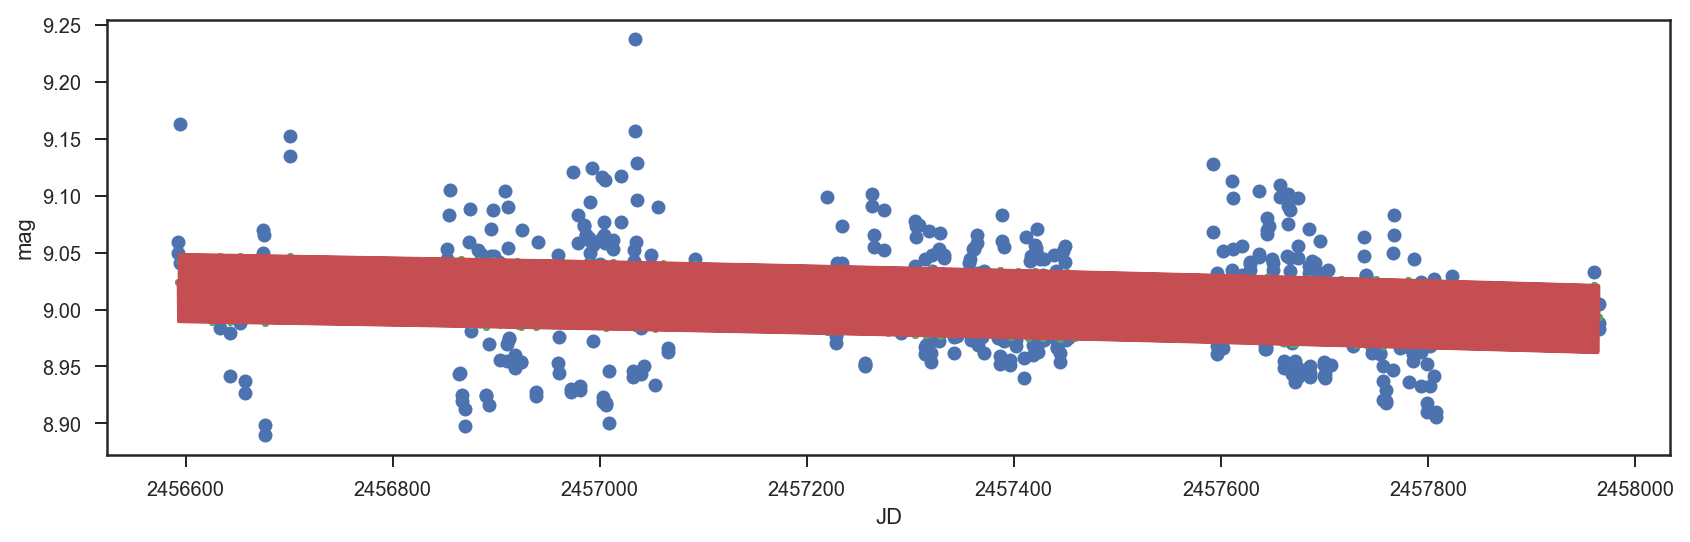

In [21]:
plt.figure(figsize=(14, 4))

plt.plot(x, y, 'o')
plt.plot(x, yfit, '.')
plt.plot(x_dense, yfit_dense)

#plt.xlim(2457200, 2457319+160)
plt.xlabel('JD')
plt.ylabel('mag');

In [22]:
omega_best = 2.0*np.pi/P_fit
mtf = astroML.time_series.MultiTermFit(omega_best, 3)

In [23]:
phased = np.mod(light_curve.time.values, P_fit)

In [24]:
mtf_fit = mtf.fit(phased, y, yerr)
phz, phz_yfit = mtf_fit.predict(100, adjust_offset=False)

(-0.3, 1.3)

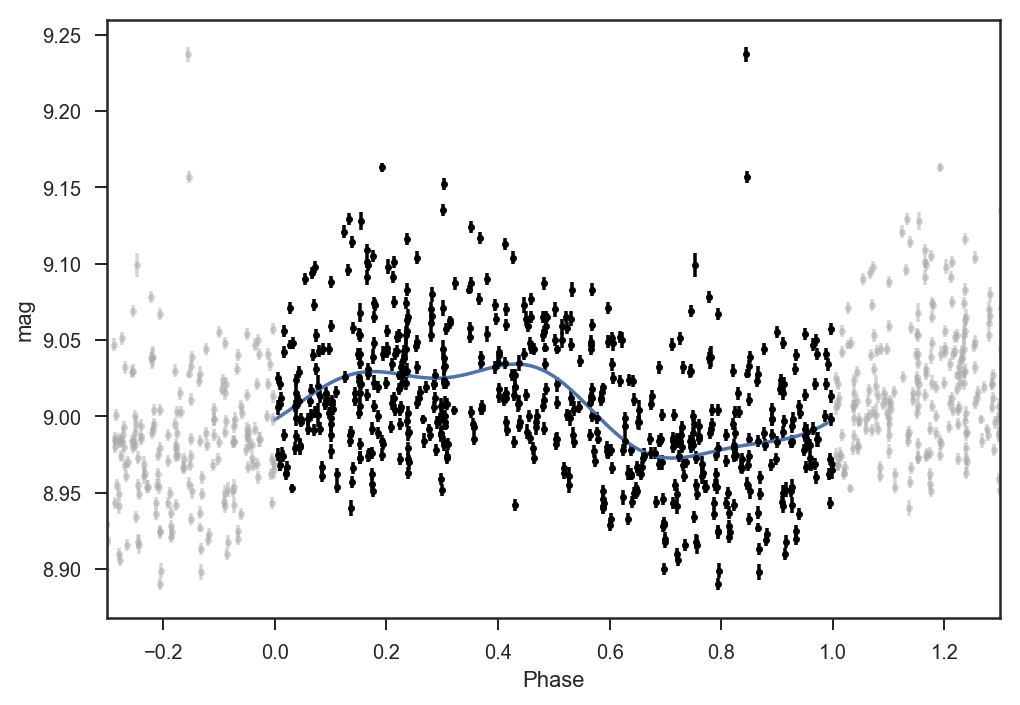

In [25]:
#plt.figure(figsize=(6,6))
    
plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('mag')

plt.plot(phz, phz_yfit)

plt.xlim(-0.3, 1.3)
#plt.ylim(13.3, 12.5)

Hmmm... need to group by observing season since the lightcurve has secular changes on timescales of ~ 1 year.

<!--NAVIGATION-->
< [Phase-folded time-series variability plots](04.01-Lightcurve-postage_stamps_by_object.ipynb) | [Contents](Index.ipynb) | [Boutique photometry collection for V819 Tau](04.03-Boutique-photometry-analysis-V819Tau.ipynb) >